Saving DATA SET AI END SEM.zip to DATA SET AI END SEM (1).zip
Found 52 CSV files.


<ipython-input-3-5991c383d0a6>:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat(df_list, ignore_index=True)


Combined data shape: (470434, 18)
Data columns after removing non-numeric: ['Prev Close', 'Open', 'High', 'Low', 'Last', 'Close', 'VWAP', 'Volume', 'Turnover', 'Trades', 'Deliverable Volume', '%Deliverble']
Training samples: 192548, Testing samples: 48138
HistGradientBoostingRegressor MSE: 23883.9541
HistGradientBoostingRegressor R-squared: 0.9980


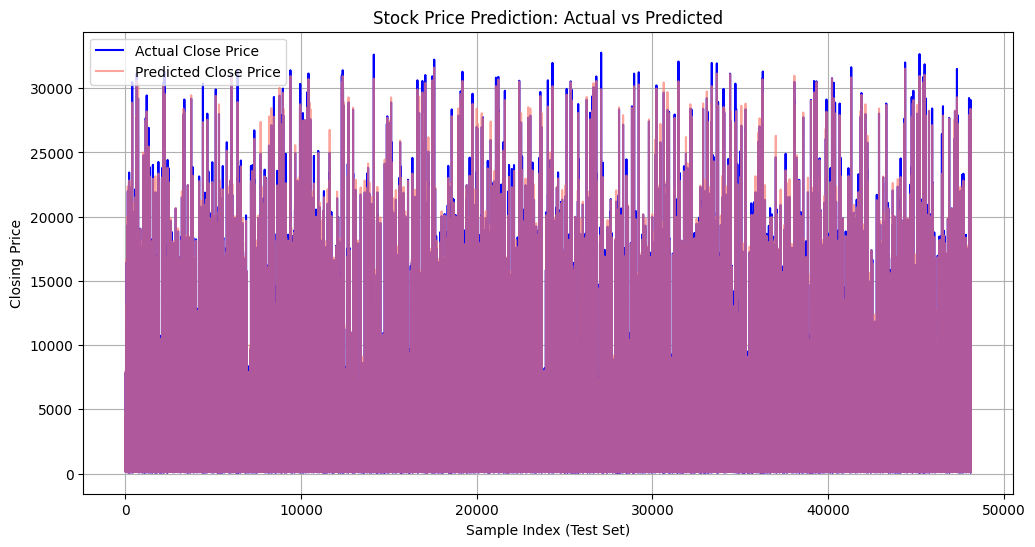

In [3]:
from google.colab import files
import pandas as pd
import zipfile
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Upload file (CSV or ZIP)
uploaded = files.upload()
file_name = next(iter(uploaded))  # Get uploaded file name

# Prepare data
df_list = []

if file_name.endswith('.zip'):
    extract_dir = 'temp_extracted'
    os.makedirs(extract_dir, exist_ok=True)

    with zipfile.ZipFile(file_name, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)

    csv_files = [os.path.join(extract_dir, f) for f in os.listdir(extract_dir) if f.endswith('.csv')]
    print(f'Found {len(csv_files)} CSV files.')

    for file in csv_files:
        df = pd.read_csv(file)
        df_list.append(df)

elif file_name.endswith('.csv'):
    print(f'Loaded single CSV: {file_name}')
    df = pd.read_csv(file_name)
    df_list.append(df)

else:
    raise ValueError("Please upload a .zip or .csv file only.")

# Combine all DataFrames
data = pd.concat(df_list, ignore_index=True)
print(f'Combined data shape: {data.shape}')

# Drop non-numeric columns
for col in data.columns:
    if not np.issubdtype(data[col].dtype, np.number):
        data.drop(columns=col, inplace=True)

print(f'Data columns after removing non-numeric: {data.columns.tolist()}')

# Add lag features for Close price
if 'Close' not in data.columns:
    raise KeyError("Column 'Close' not found. Ensure your data has a 'Close' column.")

for lag in range(1, 4):
    data[f'Close_lag_{lag}'] = data['Close'].shift(lag)

data['Close_next'] = data['Close'].shift(-1)
data.dropna(inplace=True)

# Select features
feature_cols = [col for col in data.columns if col != 'Close_next']
X = data[feature_cols]
y = data['Close_next']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f'Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}')

# Train model
gb_model = HistGradientBoostingRegressor(max_iter=100, random_state=42)
gb_model.fit(X_train_scaled, y_train)

# Evaluate
y_pred_gb = gb_model.predict(X_test_scaled)
mse_gb = mean_squared_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)

print(f'HistGradientBoostingRegressor MSE: {mse_gb:.4f}')
print(f'HistGradientBoostingRegressor R-squared: {r2_gb:.4f}')

# Plot predictions
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual Close Price', color='blue')
plt.plot(y_pred_gb, label='Predicted Close Price', color='salmon', alpha=0.7)
plt.title('Stock Price Prediction: Actual vs Predicted')
plt.xlabel('Sample Index (Test Set)')
plt.ylabel('Closing Price')
plt.legend()
plt.grid(True)
plt.show()